# Ordinary Least Squares

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.metrics import r2_score, mean_squared_error

In [28]:
data = fetch_california_housing(as_frame=True)
print(data.frame.shape)
print(data.frame.head())

(20640, 9)
   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  MedHouseVal  
0    -122.23        4.526  
1    -122.22        3.585  
2    -122.24        3.521  
3    -122.25        3.413  
4    -122.25        3.422  


In [29]:
#Removing noise from the MedHouseVal:

data_clean = data.frame[data.frame["MedHouseVal"] <= 5.0].copy()


# explanatory variables
X = data_clean.drop(columns=["MedHouseVal"])
# dependent variable (target)
y = data_clean["MedHouseVal"]  # median house value (in 100k USD)


# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

ols = LinearRegression()
ols.fit(X_train, y_train)

# Predictions & simple metrics
y_pred = ols.predict(X_test)
beta0 = ols.intercept_
beta = ols.coef_
R2 = r2_score(y_test, y_pred)
RMSE = np.sqrt(mean_squared_error(y_test, y_pred))

print("Intercept (β0):", beta0)
print("Coefficients (β):")
print(pd.Series(beta, index=X.columns))

print("R^2:", R2)
print("RMSE:", RMSE)

Intercept (β0): -33.58774986105001
Coefficients (β):
MedInc        0.426045
HouseAge      0.008211
AveRooms     -0.103072
AveBedrms     0.575254
Population    0.000005
AveOccup     -0.003136
Latitude     -0.378804
Longitude    -0.394290
dtype: float64
R^2: 0.5748697510633904
RMSE: 0.65107355051835


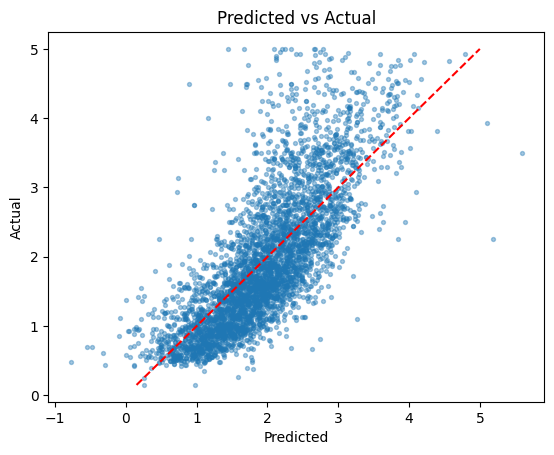

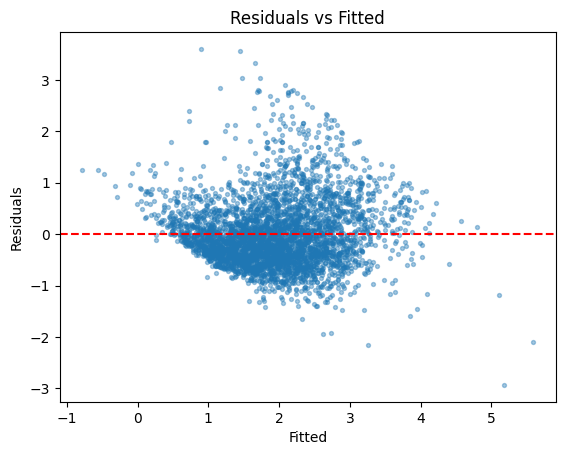

In [30]:
res = y_test - y_pred

# Predicted vs Actual
plt.scatter(y_pred, y_test, s=8, alpha=0.4)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "--", color="red")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.title("Predicted vs Actual")
plt.show()

# Residuals vs Fitted
plt.scatter(y_pred, res, s=8, alpha=0.4)
plt.axhline(0, linestyle="--", color="red")
plt.xlabel("Fitted"); plt.ylabel("Residuals")
plt.title("Residuals vs Fitted")
plt.show()

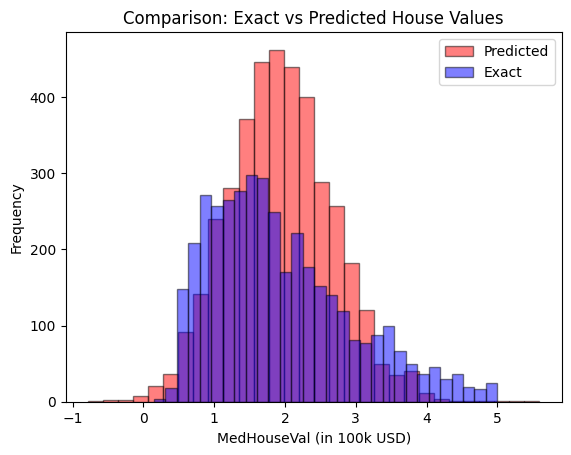

In [31]:
# distribution of MedHouseVal by frequency
plt.hist(y_pred, bins=30, alpha=0.5, label='Predicted', color='red', edgecolor='black')
plt.hist(y_test, bins=30, alpha=0.5, label='Exact', color='blue', edgecolor='black')
plt.xlabel('MedHouseVal (in 100k USD)')
plt.ylabel('Frequency')
plt.title('Comparison: Exact vs Predicted House Values')
plt.legend()
plt.show()

### One-feature slice (2D line)

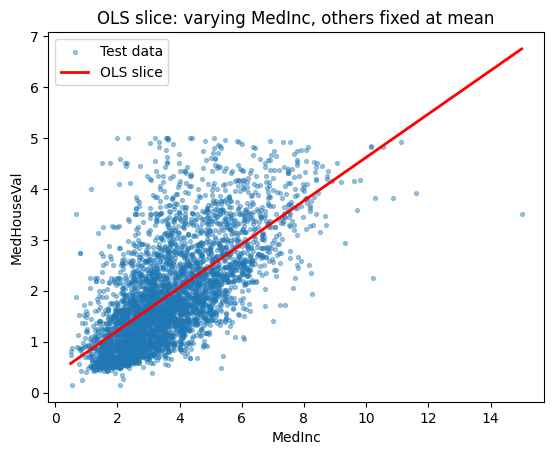

In [32]:
feat = "MedInc"
x_grid = np.linspace(X_train[feat].min(), X_train[feat].max(), 200)

# Hold others at their train means
means = X_train.mean()
X_slice = pd.DataFrame({col: means[col] for col in X_train.columns}, index=range(len(x_grid)))
X_slice[feat] = x_grid

# Predict along the slice
y_line = ols.predict(X_slice)

# Scatter actual test vs chosen feature + regression line
plt.scatter(X_test[feat], y_test, s=8, alpha=0.4, label="Test data")
plt.plot(x_grid, y_line, linewidth=2, label="OLS slice", color="red")
plt.xlabel(feat); plt.ylabel("MedHouseVal")
plt.legend(); plt.title(f"OLS slice: varying {feat}, others fixed at mean")
plt.show()

## Ridge regression

In [33]:
alphas = np.logspace(-4, 4, 50)

ridge_cv = Pipeline([
    ("scaler", StandardScaler()),
    ("ridge", RidgeCV(alphas=alphas)) # scoring='neg_mean_squared_error' by default if cv=None
])

ridge_cv.fit(X_train, y_train)
best_alpha = ridge_cv.named_steps["ridge"].alpha_

# Predictions & simple metrics
y_ridge_pred = ridge_cv.predict(X_test)
R2_ridge = r2_score(y_test, y_ridge_pred)
RMSE_ridge = np.sqrt(mean_squared_error(y_test, y_ridge_pred))

# Extract scaled coefficients
beta0_scaled = ridge_cv.named_steps["ridge"].intercept_
beta_scaled = ridge_cv.named_steps["ridge"].coef_

# Adjust coefficients back to original scale
scaler = ridge_cv.named_steps["scaler"]
beta0_ridge = beta0_scaled - np.sum(beta_scaled * scaler.mean_ / scaler.scale_)
beta_ridge = beta_scaled / scaler.scale_


print("Best alpha:", best_alpha)
print("Intercept (β0):", beta0_ridge)
print("Coefficients (β):")
print(pd.Series(beta_ridge, index=X.columns))

print("R^2:", R2_ridge)
print("RMSE:", RMSE_ridge)

Best alpha: 35.564803062231285
Intercept (β0): -32.49227172033862
Coefficients (β):
MedInc        0.425800
HouseAge      0.008420
AveRooms     -0.101484
AveBedrms     0.563219
Population    0.000006
AveOccup     -0.003149
Latitude     -0.367058
Longitude    -0.381613
dtype: float64
R^2: 0.5743593137473388
RMSE: 0.6514642925812365


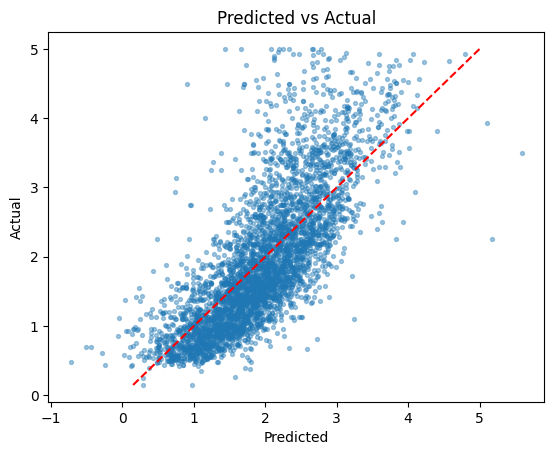

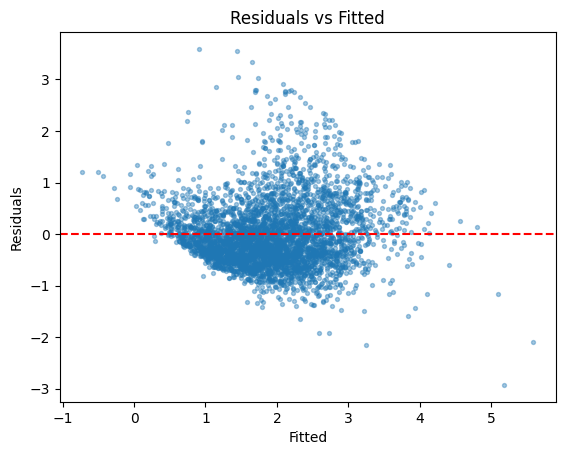

In [34]:
res = y_test - y_ridge_pred

# Predicted vs Actual
plt.scatter(y_ridge_pred, y_test, s=8, alpha=0.4)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "--", color="red")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.title("Predicted vs Actual")
plt.show()

# Residuals vs Fitted
plt.scatter(y_ridge_pred, res, s=8, alpha=0.4)
plt.axhline(0, linestyle="--", color="red")
plt.xlabel("Fitted"); plt.ylabel("Residuals")
plt.title("Residuals vs Fitted")
plt.show()

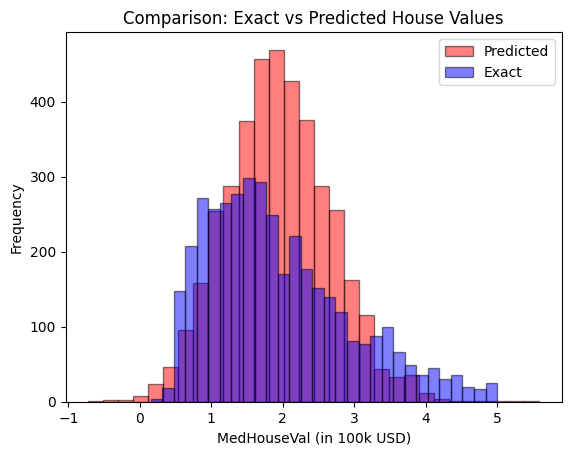

In [35]:
# distribution of MedHouseVal by frequency
plt.hist(y_ridge_pred, bins=30, alpha=0.5, label='Predicted', color='red', edgecolor='black')
plt.hist(y_test, bins=30, alpha=0.5, label='Exact', color='blue', edgecolor='black')
plt.xlabel('MedHouseVal (in 100k USD)')
plt.ylabel('Frequency')
plt.title('Comparison: Exact vs Predicted House Values')
plt.legend()
plt.show()

## Lasso

In [36]:
alphas = np.logspace(-4, 4, 50)

lasso_cv = Pipeline([
    ("scaler", StandardScaler()),
    ("lasso", LassoCV(alphas=alphas))
])

lasso_cv.fit(X_train, y_train)
best_alpha = lasso_cv.named_steps["lasso"].alpha_

# Predictions & simple metrics
y_lasso_pred = lasso_cv.predict(X_test)
R2_lasso = r2_score(y_test, y_lasso_pred)
RMSE_lasso = np.sqrt(mean_squared_error(y_test, y_lasso_pred))

# Extract scaled coefficients
beta0_scaled = lasso_cv.named_steps["lasso"].intercept_
beta_scaled = lasso_cv.named_steps["lasso"].coef_

# Adjust coefficients back to original scale
scaler = lasso_cv.named_steps["scaler"]
beta0_lasso = beta0_scaled - np.sum(beta_scaled * scaler.mean_ / scaler.scale_)
beta_lasso = beta_scaled / scaler.scale_


print("Best alpha:", best_alpha)
print("Intercept (β0):", beta0_lasso)
print("Coefficients (β):")
print(pd.Series(beta_lasso, index=X.columns))

print("R^2:", R2_lasso)
print("RMSE:", RMSE_lasso)

Best alpha: 0.0020235896477251557
Intercept (β0): -32.65886754102846
Coefficients (β):
MedInc        0.419260
HouseAge      0.008198
AveRooms     -0.091644
AveBedrms     0.517144
Population    0.000003
AveOccup     -0.002938
Latitude     -0.370260
Longitude    -0.384219
dtype: float64
R^2: 0.5736336930818877
RMSE: 0.6520193554217762


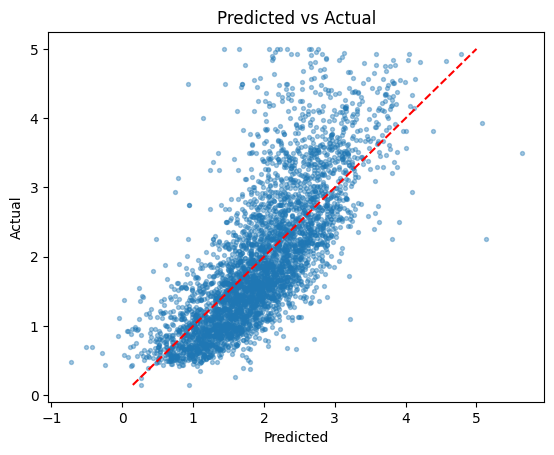

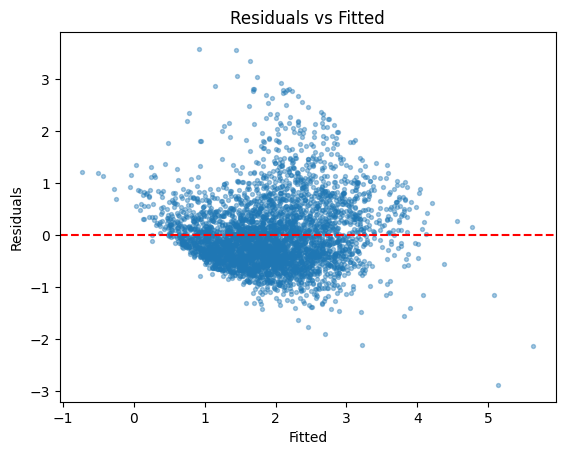

In [37]:
res = y_test - y_lasso_pred

# Predicted vs Actual
plt.scatter(y_lasso_pred, y_test, s=8, alpha=0.4)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "--", color="red")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.title("Predicted vs Actual")
plt.show()

# Residuals vs Fitted
plt.scatter(y_lasso_pred, res, s=8, alpha=0.4)
plt.axhline(0, linestyle="--", color="red")
plt.xlabel("Fitted"); plt.ylabel("Residuals")
plt.title("Residuals vs Fitted")
plt.show()

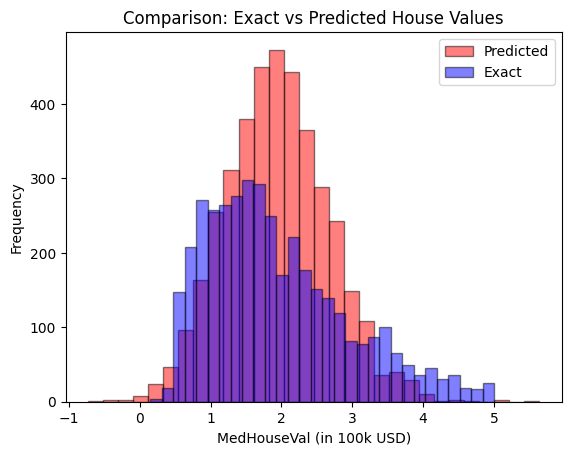

In [38]:
# distribution of MedHouseVal by frequency
plt.hist(y_lasso_pred, bins=30, alpha=0.5, label='Predicted', color='red', edgecolor='black')
plt.hist(y_test, bins=30, alpha=0.5, label='Exact', color='blue', edgecolor='black')
plt.xlabel('MedHouseVal (in 100k USD)')
plt.ylabel('Frequency')
plt.title('Comparison: Exact vs Predicted House Values')
plt.legend()
plt.show()